# Código One Class Classification

## Imports

In [171]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import numpy.linalg as LA
from functools import reduce

## Funções de Suporte

## K-distance

Este algoritmo é o que foi proposto na questão da prova correspondente a esta lista.
Para classificar uma amostra, são calculados os k pontos (amostras do treinamento) mais próximos e em seguida, para cada um deles é calculada a distância do k-ésimo ponto mais próximo dele. Para pertencer à mesma classe dos pontos, a distância entre a amostra e cada um deles deve ser menor ou igual à distância do k-ésimo ponto mais próximo de cada.

In [172]:
class KDistance:
    def __init__(self, k = 3, label = 0, positive = False):
        self.k = k
        self.nn = NearestNeighbors()
        self.label = label
        self.positive = positive
    
    def train(self, training):
        self.samples = training
        self.nn.fit(self.samples)
        self.distances = self.nn.kneighbors(n_neighbors=self.k)[0][:,-1]
        #print(self.distances)
    
    def predict(self, samples):
        def count_true(array):
            unique, counts = np.unique(array, return_counts=True)
            return counts[np.where(unique == True)][0] if True in unique else 0
            
        distances, closest = self.nn.kneighbors(X = samples, n_neighbors=self.k)
        distances_closest = self.distances[closest]
        
        #votes = np.less_equal(distances, distances_closest)
        #return np.array([(count_true(i) << 1) >= self.k for i in votes])
        return np.less_equal(distances, distances_closest).all(axis=1)
    
    def test(self, testing):
        samples = testing[:, :-1]
        labels = (testing[:, -1] == self.label) == self.positive
        predicted_labels = self.predict(samples) == self.positive
        result = KDistance.calculate_test_results(labels, predicted_labels)
        return result
    
    @staticmethod
    def calculate_test_results(labels, predicted):
        #print(labels)
        #print(predicted)
        
        unique, counts = np.unique(np.logical_and(labels, predicted), return_counts=True)
        true_pos = counts[np.where(unique == True)][0] if True in unique else 0
        #print(true_pos)
        
        unique, counts = np.unique(np.logical_and(np.logical_not(labels), predicted), return_counts=True)
        false_pos = counts[np.where(unique == True)][0] if True in unique else 0
        #print(false_pos)
        
        unique, counts = np.unique(np.logical_and(labels, np.logical_not(predicted)), return_counts=True)
        false_neg = counts[np.where(unique == True)][0] if True in unique else 0
        #print(false_neg)
        
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        #print(precision)
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        #print(recall)
        
        return {
            "true_pos": true_pos / len(labels),
            "false_pos": false_pos / len(labels),
            "false_neg": false_neg / len(labels),
            "f1": 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        }

In [173]:
kdist = KDistance()
kdist.train(np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]]))
#print(kdist.predict(np.array([[0, 0], [0, 5]])))
kdist.test(np.array([[0, 0, 0], [0, 3, 1], [0, 4, 1], [0, 5, 1]]))

{'true_pos': 0.5, 'false_pos': 0.0, 'false_neg': 0.25, 'f1': 0.8}

# Avaliações

## Imports

In [174]:
%matplotlib inline

from scipy.io import arff
import pandas as pd
from time import process_time

import matplotlib
import matplotlib.pyplot as plt
from statistics import mean

## Funções para o experimento

In [175]:
# Remove rows with nans on them
def remove_nans(array):
    '''Removes rows with nans on them.'''
    return array[~np.any(np.isnan(array), axis=1)]

In [176]:
def normalize(raw):
    '''Normalizes an dataset so all of its attributes have the same weight.'''
    attribute_mins = np.min(raw, axis=0)
    attribute_maxs = np.max(raw, axis=0)
    return (raw - attribute_mins) / attribute_maxs

In [177]:
def k_fold(sepSamples, k):
    '''Splits the samples in k groups with similar amounts of samples and distributions of every class.'''
    folds = [[None, None] for _ in range(k)]
    splitClass = [None, None]
    splitClass[0] = np.array_split(sepSamples[0], k)
    splitClass[1] = np.array_split(sepSamples[1], k)
    for a in range(k):
        folds[a][0] = splitClass[0][a]
        folds[a][1] = splitClass[1][a]
    return folds

In [178]:
def cross_validation(machine, folds):
    '''Evaluates a machine through cross-validation.'''
    true_pos = []
    false_pos = []
    false_neg = []
    f1 = []
    train_times = []
    test_times = []
    for i in range(len(folds)):
        print("Testing on fold " + str(i))
        train_folds = [fold[0] for f, fold in enumerate(folds) if i != f]
        train = np.concatenate(train_folds)[:,:-1]
        discarded_train_folds = [fold[1] for f, fold in enumerate(folds) if i != f]
        discarded_train = np.concatenate(discarded_train_folds)
        test = np.concatenate((folds[i][0], folds[i][1], discarded_train))
        
        train_times.append(process_time())
        machine.train(train)
        train_times[-1] = process_time() - train_times[-1]

        test_times.append(process_time())
        test_results = machine.test(test)
        test_times[-1] = process_time() - test_times[-1]

        true_pos.append(test_results['true_pos'])
        false_pos.append(test_results['false_pos'])
        false_neg.append(test_results['false_neg'])
        f1.append(test_results['f1'])
    return {
        'true_pos': true_pos,
        'false_pos': false_pos,
        'false_neg': false_neg,
        'f1': f1,
        'train_times': train_times,
        'test_times': test_times
    }

In [179]:
def experiment(machine, folds, kVariations = [1, 2, 3, 5, 7, 9, 11, 13, 15]):
    '''The code which will run the experiment.'''
    result = {}
    for i in kVariations:
        print('Parameter k = ' + str(i))
        machine.k = i
        result[i] = cross_validation(machine, folds)
    return result

## Base de Dados 1 - CM1

### Preparação

In [192]:
data = arff.loadarff('Datasets/cm1.arff')
dataFrame = pd.DataFrame(data[0])
dataFrame.defects = [1 if i == b'true' else 0 for i in dataFrame.defects]
rawData = dataFrame.values
#rawData

In [193]:
# Removes the nans
rawData = remove_nans(rawData)

In [194]:
# Normalizing the dataset
normalizedData = normalize(rawData)

In [195]:
# Separating samples by class
classes = [None, None]
classes[0] = rawData[np.where(rawData[:,-1] == 0)]
classes[1] = rawData[np.where(rawData[:,-1] == 1)]
#classes

In [196]:
# Separating the folds
folds = k_fold(classes, k = 10)
#folds

### Execução

In [206]:
kdist = KDistance()
cm1_results = experiment(kdist, folds, kVariations = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])
cm1_results

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 11
Tes

{1: {'true_pos': [0.2553191489361702,
   0.23404255319148937,
   0.23404255319148937,
   0.2765957446808511,
   0.26595744680851063,
   0.23404255319148937,
   0.24468085106382978,
   0.2127659574468085,
   0.22340425531914893,
   0.20430107526881722],
  'false_pos': [0.13829787234042554,
   0.11702127659574468,
   0.22340425531914893,
   0.23404255319148937,
   0.14893617021276595,
   0.20212765957446807,
   0.23404255319148937,
   0.1595744680851064,
   0.2553191489361702,
   0.12903225806451613],
  'false_neg': [0.26595744680851063,
   0.2872340425531915,
   0.2872340425531915,
   0.24468085106382978,
   0.2553191489361702,
   0.2872340425531915,
   0.2765957446808511,
   0.30851063829787234,
   0.2978723404255319,
   0.3225806451612903],
  'f1': [0.5581395348837208,
   0.5365853658536586,
   0.47826086956521735,
   0.5360824742268041,
   0.5681818181818182,
   0.4888888888888889,
   0.48936170212765956,
   0.47619047619047616,
   0.44680851063829785,
   0.4749999999999999],
  'trai

### Resultados

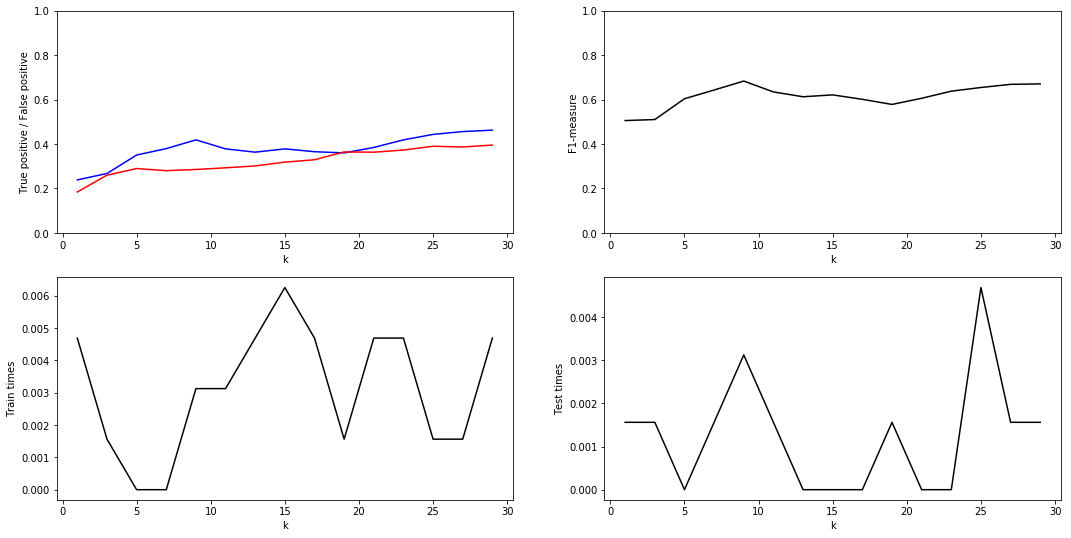

In [219]:
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
kVariations =  [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

axes[0,0].plot(kVariations, [mean(cm1_results[i]['true_pos']) for i in kVariations], 'b')
axes[0,0].plot(kVariations, [mean(cm1_results[i]['false_pos']) for i in kVariations], 'r')
axes[0,1].plot(kVariations, [mean(cm1_results[i]['f1']) for i in kVariations], 'k')
axes[1,0].plot(kVariations, [mean(cm1_results[i]['train_times']) for i in kVariations], 'k')
axes[1,1].plot(kVariations, [mean(cm1_results[i]['test_times']) for i in kVariations], 'k')

axes[0,0].set_xlabel('k')
axes[0,0].set_ylabel('True positive / False positive')
axes[0,0].set_ylim(0, 1)

axes[0,1].set_xlabel('k')
axes[0,1].set_ylabel('F1-measure')
axes[0,1].set_ylim(0, 1)

axes[1,0].set_xlabel('k')
axes[1,0].set_ylabel('Train times')

axes[1,1].set_xlabel('k')
axes[1,1].set_ylabel('Test times')

plt.show()

## Base de Dados 2 - JM1

### Preparação

In [220]:
data = arff.loadarff('Datasets/jm1.arff')
dataFrame = pd.DataFrame(data[0])
dataFrame.defects = [1 if i == b'true' else 0 for i in dataFrame.defects]
rawData = dataFrame.values
#rawData

In [221]:
# Removes the nans
rawData = remove_nans(rawData)

In [222]:
# Normalizing the dataset
normalizedData = normalize(rawData)

In [223]:
# Separating samples by class
classes = [None, None]
classes[0] = normalizedData[np.where(rawData[:,-1] == 0)]
classes[1] = normalizedData[np.where(rawData[:,-1] == 1)]
#classes

In [224]:
# Separating the folds
folds = k_fold(classes, k = 10)
#folds

### Execução

In [225]:
kdist = KDistance()
jm1_results = experiment(kdist, folds, kVariations =  [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])
jm1_results

Parameter k = 1
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 3
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 5
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 7
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 9
Testing on fold 0
Testing on fold 1
Testing on fold 2
Testing on fold 3
Testing on fold 4
Testing on fold 5
Testing on fold 6
Testing on fold 7
Testing on fold 8
Testing on fold 9
Parameter k = 11
Tes

{1: {'true_pos': [0.38108017443810804,
   0.3693391479369339,
   0.37537739013753774,
   0.3767192217376719,
   0.37604830593760485,
   0.3787319691378732,
   0.3750419322375042,
   0.37583892617449666,
   0.38422818791946306,
   0.374496644295302],
  'false_pos': [0.15363971821536399,
   0.14022140221402213,
   0.15397517611539752,
   0.1231130493123113,
   0.14961422341496142,
   0.14324052331432405,
   0.13820865481382086,
   0.13993288590604028,
   0.15805369127516777,
   0.13691275167785236],
  'false_neg': [0.3243877893324388,
   0.33612881583361287,
   0.33009057363300903,
   0.32874874203287485,
   0.32941965783294197,
   0.3267359946326736,
   0.3304260315330426,
   0.32986577181208054,
   0.3214765100671141,
   0.33120805369127515],
  'f1': [0.6145523397349202,
   0.6079514080618442,
   0.6079869600651997,
   0.6251043696075702,
   0.6108991825613079,
   0.617108499590052,
   0.6154693091109277,
   0.6153846153846154,
   0.6157569239042754,
   0.6153846153846154],
  'train_ti

### Resultados

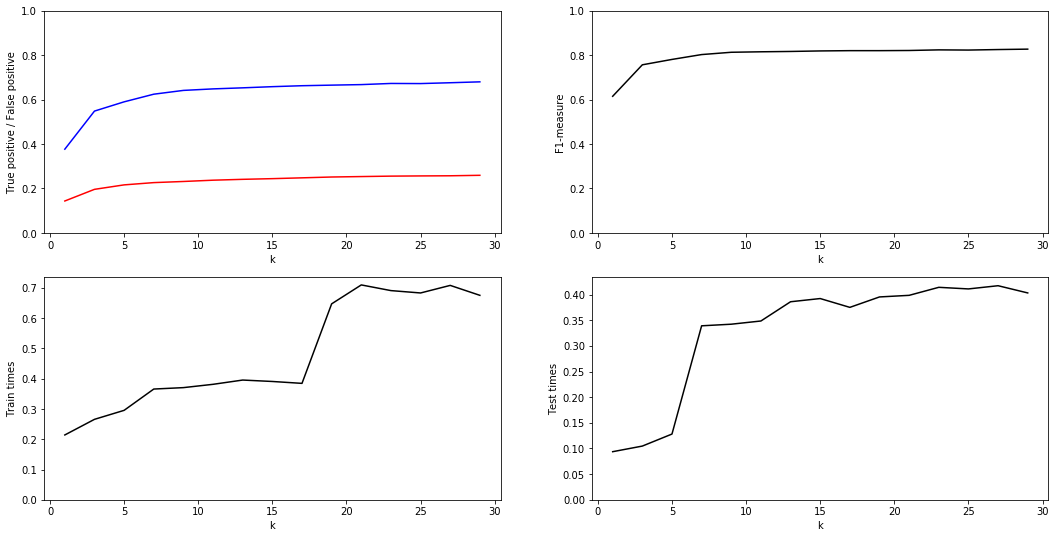

In [227]:
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
kVariations =  [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

axes[0,0].plot(kVariations, [mean(jm1_results[i]['true_pos']) for i in kVariations], 'b')
axes[0,0].plot(kVariations, [mean(jm1_results[i]['false_pos']) for i in kVariations], 'r')
axes[0,1].plot(kVariations, [mean(jm1_results[i]['f1']) for i in kVariations], 'k')
axes[1,0].plot(kVariations, [mean(jm1_results[i]['train_times']) for i in kVariations], 'k')
axes[1,1].plot(kVariations, [mean(jm1_results[i]['test_times']) for i in kVariations], 'k')

axes[0,0].set_xlabel('k')
axes[0,0].set_ylabel('True positive / False positive')
axes[0,0].set_ylim(0, 1)

axes[0,1].set_xlabel('k')
axes[0,1].set_ylabel('F1-measure')
axes[0,1].set_ylim(0, 1)

axes[1,0].set_xlabel('k')
axes[1,0].set_ylabel('Train times')
axes[1,0].set_ylim(0)

axes[1,1].set_xlabel('k')
axes[1,1].set_ylabel('Test times')
axes[1,1].set_ylim(0)

plt.show()